# Purpose and goals
In this notebook you will implement a simple neural network in PyTorch.

The building blocks of PyTorch are Tensors, and Operations, with these we can form dynamic computational graphs that represent neural networks.
In this exercise we'll start right away by defining a logistic regression model using these simple building blocks.
We'll initially start with a simple 2D and binary (i.e. two-class) classification problem where the class decision boundary can be visualized.
Initially we show that logistic regression can only separate classes linearly.
Adding a nonlinear hidden layer to the algorithm permits nonlinear class separation.

In this notebook you should:
* **First** run the code as is, and see what it does.
* **Then** modify the code, following the instructions in the bottom of the notebook.
* **Lastly** play around a bit, and do some small experiments that you come up with.

> We assume that you are already familiar with backpropagation (if not please see [Andrej Karpathy](http://cs.stanford.edu/people/karpathy/) or [Michal Nielsen](http://neuralnetworksanddeeplearning.com/chap2.html)).

# Dependencies and supporting functions
Load dependencies and supporting functions by running the code block below.

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

# Do not worry about the code below for now, it is used for plotting later
def plot_decision_boundary(pred_func, X, y):
    #from https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    yy = yy.astype('float32')
    xx = xx.astype('float32')
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])[:,0]
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=-y, cmap=plt.cm.Spectral)

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

# Problem 
We'll initally demonstrate that Multi-layer Perceptrons (MLPs) can classify nonlinear problems, whereas a simple logistic regression model cannot.
For ease of visualization and computational speed we initially experiment on the simple 2D half-moon dataset, visualized below.

(300, 2) (300,)


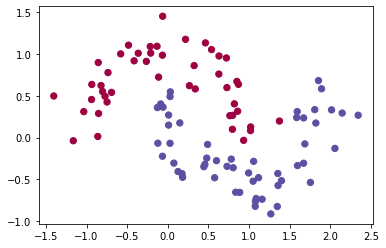

In [2]:
# Generate a dataset and plot it
np.random.seed(0)
num_samples = 300

X, y = sklearn.datasets.make_moons(num_samples, noise=0.20)

# define train, validation, and test sets
X_tr = X[:100].astype('float32')
X_val = X[100:200].astype('float32')
X_te = X[200:].astype('float32')

# and labels
y_tr = y[:100].astype('int32')
y_val = y[100:200].astype('int32')
y_te = y[200:].astype('int32')

plt.scatter(X_tr[:,0], X_tr[:,1], s=40, c=y_tr, cmap=plt.cm.Spectral)

print(X.shape, y.shape)

num_features = X_tr.shape[-1]
num_output = 2

# From Logistic Regression to "Deep Learning"
The code implements logistic regression. In section [__Assignments Half Moon__](#Assignments-Half-Moon) (bottom of this notebook) you are asked to modify the code into a neural network.

The standard building block for neural networks are layers, the simplest of which is called a *fully-connected layer* or *dense feed forward layer*, and it is computed as follows:

$$y = g(W^{\top} x + b)$$

where $x$ is the input vector, $y$ is the output vector, $W, b$ are the weights and biases (a matrix and vector respectively) and $g$ is a non-linear function, called *activation function*.
The *dense* part of the name comes from the fact that every element of $x$ contributes to every element of $y$.
And the *feed forward* part of the name means that the layer processes each input independently. 
If we were to draw the layer it would be acyclical.
Later we will see layers that break from both of these conventions.

- $x$ has shape `[batch_size, num_features]`,
- $W$ has shape `[num_units, num_features]`,
- $b$ has `[num_units]`, and
- $y$ has then `[batch_size, num_units]`

## PyTorch 101

In this first exercise we will use basic PyTorch functions so that you can learn how to build it from scratch. This will help you later if you want to build your own custom operations.

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

[`Parameters`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#torch.nn.parameter.Parameter) have a very special property when used with [`Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=module#torch.nn.Module)s - when they’re assigned as `Module` attributes they are automatically added to the list of its parameters, and will appear e.g. in the `parameters()` iterator. \
Assigning a Tensor doesn’t have such effect. This is because one might want to cache some temporary state (more on this later) in the model. If there was no such class as `Parameter`, these temporaries would get registered too.

In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # Setting up variables, these variables are weights in your 
        # network that can be updated while running our graph.
        # Notice, to make a hidden layer, the weights need to have the 
        # following dimensionality:
        #   W[number_of_units_going_out, number_of_units_going_in]
        #   b[number_of_units_going_out]
        # in the example below we have 2 input units (num_features) and 2 output units (num_output)
        # so our weights become W[2, 2], b[2]
        # if we want to make a hidden layer with 100 units, we need to define the shape of the
        # first weight to W[100, 2], b[2] and the shape of the second weight to W[2, 100], b[2]
        
        # first layer
        self.W_1 = nn.Parameter(torch.randn(num_output, num_features)) 
        self.b_1 = nn.Parameter(torch.randn(num_output))
        
        # second layer (to be completed as an exercise)
        # NB when you create a second layer, remember that you also must change parts of the first layer
        # self.W_2 = <YOUR CODE HERE>
        # self.b_2 = <YOUR CODE HERE>
        
    def forward(self, x):
        # Setting up ops, these ops will define edges along our computational graph
        # The below ops will compute a logistic regression, 
        # but can be modified to compute a neural network
        x = F.linear(x, self.W_1, self.b_1)
        
        # second layer (to be completed as an exercise)
        # NB when you create a second layer, remember that you also must change parts of the first layer
        # x = F.linear(x, self.W_2, self.b_2)
        return F.softmax(x, dim=1) # softmax to be performed on the second dimension

net = Net()

Knowing how to print your tensors is useful

In [6]:
# list all parameters in your network
print("NAMED PARAMETERS")
print(list(net.named_parameters()))
print()
# the .parameters() method simply gives the Tensors in the list
print("PARAMETERS")
print(list(net.parameters()))
print()

# list individual parameters by name
print('WEIGHTS')
print(net.W_1)
print(net.W_1.size())
print('\nBIAS')
print(net.b_1)
print(net.b_1.size())

NAMED PARAMETERS
[('W_1', Parameter containing:
tensor([[-2.1261,  0.1309],
        [ 0.4049,  0.4105]], requires_grad=True)), ('b_1', Parameter containing:
tensor([-2.1213, -0.2611], requires_grad=True))]

PARAMETERS
[Parameter containing:
tensor([[-2.1261,  0.1309],
        [ 0.4049,  0.4105]], requires_grad=True), Parameter containing:
tensor([-2.1213, -0.2611], requires_grad=True)]

WEIGHTS
Parameter containing:
tensor([[-2.1261,  0.1309],
        [ 0.4049,  0.4105]], requires_grad=True)
torch.Size([2, 2])

BIAS
Parameter containing:
tensor([-2.1213, -0.2611], requires_grad=True)
torch.Size([2])


# Exploring Parameter

Ok, let's investigate what a Parameter is

In [7]:
param = net.W_1
print("## this is the tensor")
print(param.data)
print("\n## this is the tensor's gradient")
print(param.grad)
# notice, the gradient is undefined because we have not yet run a backward pass

print("\n## is it a leaf in the graph?")
print(param.is_leaf)

## this is the tensor
tensor([[-2.1261,  0.1309],
        [ 0.4049,  0.4105]])

## this is the tensor's gradient
None

## is it a leaf in the graph?
True


## Excluding subgraphs from backward propagation

To exclude part of your computational graph (i.e. a subgraph) from backward propagation, simply set the relevant tensors' attribute `requires_grad` to `False`.

If there’s a single input to an operation that requires gradient, its output will also require gradient. Conversely, only if all inputs don’t require gradient, the output also won’t require it. Backward computation is never performed in the subgraphs, where all Tensors didn’t require gradients.

# Test network

To use our network we can simply call our graph, and it will dynamically be created. Here is an example of running the network's forward pass.

In [8]:
X = torch.randn(5, num_features)
# the net.__call__ runs some pre-defined functions
# both before and after running net.forward()
# see http://pytorch.org/docs/master/_modules/torch/nn/modules/module.html

print('input')
print(X)

print('\noutput')
print(net(X))

input
tensor([[ 1.6606,  1.8592],
        [ 1.8436, -0.5669],
        [ 0.0472, -0.8556],
        [-0.6538,  0.2246],
        [-0.5064, -0.9468]])

output
tensor([[0.0014, 0.9986],
        [0.0017, 0.9983],
        [0.1493, 0.8507],
        [0.4334, 0.5666],
        [0.4222, 0.5778]], grad_fn=<SoftmaxBackward0>)


`Parameter`s are a special kind of `Tensor`

In [9]:
# let's take a look at the gradients
for p in net.parameters():
    print(p.data)
    print(p.grad)
    print()

tensor([[-2.1261,  0.1309],
        [ 0.4049,  0.4105]])
None

tensor([-2.1213, -0.2611])
None



In [10]:
X = torch.randn(7, num_features)
out = net(X)
# we need to give a tensor of gradients to .backward,
# we give a dummy tensor
out.backward(torch.randn(7, num_output))

for details on `.backward()`, see http://pytorch.org/docs/master/autograd.html#torch.autograd.backward

In [11]:
# let's take a look at the gradients
for p in net.parameters():
    print(p.data)
    print(p.grad)
    print()

tensor([[-2.1261,  0.1309],
        [ 0.4049,  0.4105]])
tensor([[-0.6037,  0.0578],
        [ 0.6037, -0.0578]])

tensor([-2.1213, -0.2611])
tensor([ 1.4283, -1.4283])



In [12]:
# ok, let's try and zero the accumulated gradients
net.zero_grad()
for p in net.parameters():
    print(p.data)
    print(p.grad)

tensor([[-2.1261,  0.1309],
        [ 0.4049,  0.4105]])
tensor([[0., 0.],
        [0., 0.]])
tensor([-2.1213, -0.2611])
tensor([0., 0.])


# Loss function

Let's define a custom loss function to compute how good our graph is doing.

In [13]:
def cross_entropy(ys, ts):
    # computing cross entropy per sample
    cross_entropy = -torch.sum(ts * torch.log(ys), dim=1, keepdim=False)
    # averaging over samples
    return torch.mean(cross_entropy)

To train our neural network we need to update the parameters in the direction of the negative gradient w.r.t the cost function we defined earlier.
We can use [`torch.optim`](http://pytorch.org/docs/master/optim.html) to get the gradients with some update rule for all parameters in the network.

Heres a small animation of gradient descent: http://imgur.com/a/Hqolp, which also illustrates which challenges optimizers might face, e.g. saddle points.

In [14]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)

Next, we make the prediction functions, such that we can get an accuracy measure over a batch

In [15]:
def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], torch.max(ts, 1)[1])
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

The next step is to utilize our `optimizer` repeatedly in order to optimize our weights `W_1` and `b_1` to make the best possible linear seperation of the half moon dataset.

Epoch 0, Train Cost: 1.102	Val Cost: 1.309	 Val acc: 0.560
Epoch 100, Train Cost: 0.820	Val Cost: 0.972	 Val acc: 0.640
Epoch 200, Train Cost: 0.635	Val Cost: 0.746	 Val acc: 0.710
Epoch 300, Train Cost: 0.524	Val Cost: 0.604	 Val acc: 0.750
Epoch 400, Train Cost: 0.458	Val Cost: 0.517	 Val acc: 0.730
Epoch 500, Train Cost: 0.420	Val Cost: 0.464	 Val acc: 0.780
Epoch 600, Train Cost: 0.398	Val Cost: 0.432	 Val acc: 0.770
Epoch 700, Train Cost: 0.384	Val Cost: 0.412	 Val acc: 0.760
Epoch 800, Train Cost: 0.374	Val Cost: 0.398	 Val acc: 0.780
Epoch 900, Train Cost: 0.366	Val Cost: 0.388	 Val acc: 0.800

Test Cost: 0.335	Test Accuracy: 0.840


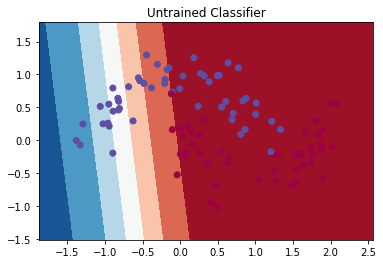

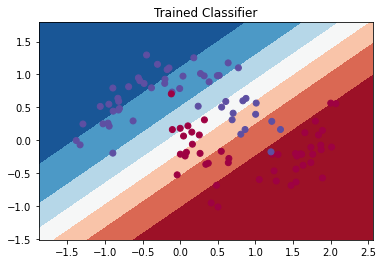

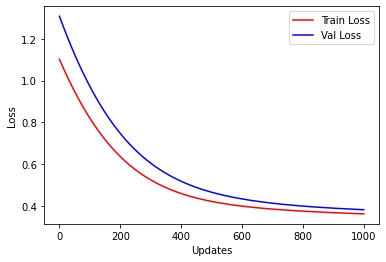

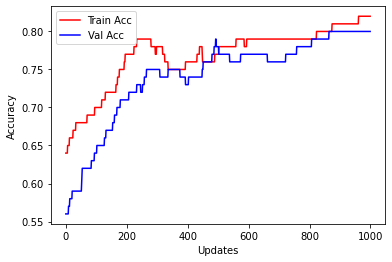

In [16]:
# number of training passses
num_epochs = 1000
# store loss and accuracy for information
train_losses, val_losses, train_accs, val_accs = [], [], [], []

def pred(X):
    """ Compute graph's prediction and return numpy array
    
    Parameters
    ----------
    X : numpy.ndarray
    
    Returns
    -------
    numpy.ndarray
    """
    X = torch.from_numpy(X)
    y = net(X)
    return y.data.numpy()

# plot boundary on testset before training session
plot_decision_boundary(lambda x: pred(x), X_te, y_te)
plt.title("Untrained Classifier")

# training loop
for e in range(num_epochs):
    # get training input and expected output as torch Variables and make sure type is correct
    tr_input = torch.from_numpy(X_tr)
    tr_targets = torch.from_numpy(onehot(y_tr, num_output)).float()
    
    # zeroize accumulated gradients in parameters
    optimizer.zero_grad()
    # predict by running forward pass
    tr_output = net(tr_input)
    # compute cross entropy loss
    tr_loss = cross_entropy(tr_output, tr_targets)
    # compute gradients given loss
    tr_loss.backward()
    # update the parameters given the computed gradients
    optimizer.step()
    train_acc = accuracy(tr_output, tr_targets)
    
    # store training loss
    train_losses.append(tr_loss.data.numpy())
    train_accs.append(train_acc)
    
    # get validation input and expected output as torch Variables and make sure type is correct
    val_input = torch.from_numpy(X_val)
    val_targets = torch.from_numpy(onehot(y_val, num_output)).float()
    
    # predict with validation input
    val_output = net(val_input)
    # compute loss and accuracy
    val_loss = cross_entropy(val_output, val_targets)
    val_acc = accuracy(val_output, val_targets)
    
    # store loss and accuracy
    val_losses.append(val_loss.data.numpy())
    val_accs.append(val_acc.data.numpy())
    
    if e % 100 == 0:
        print("Epoch %i, "
              "Train Cost: %0.3f"
              "\tVal Cost: %0.3f"
              "\t Val acc: %0.3f" % (e, 
                                     train_losses[-1],
                                     val_losses[-1],
                                     val_accs[-1]))
        
        
# get test input and expected output
te_input = torch.from_numpy(X_te)
te_targets = torch.from_numpy(onehot(y_te, num_output)).float()
# predict on testset
te_output = net(te_input)
# compute loss and accuracy
te_loss = cross_entropy(te_output, te_targets)
te_acc = accuracy(te_output, te_targets)
print("\nTest Cost: %0.3f\tTest Accuracy: %0.3f" % (te_loss.data.numpy(), te_acc.data.numpy()))

# plot boundary on testset after training session
plot_decision_boundary(lambda x: pred(x), X_te, y_te)
plt.title("Trained Classifier")

plt.figure()
epoch = np.arange(len(train_losses))
plt.plot(epoch, train_losses, 'r', label='Train Loss')
plt.plot(epoch, val_losses, 'b', label='Val Loss')
plt.legend()
plt.xlabel('Updates')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(epoch, train_accs, 'r', label='Train Acc')
plt.plot(epoch, val_accs, 'b', label='Val Acc')
plt.legend()
plt.xlabel('Updates')
plt.ylabel('Accuracy')
plt.show()

# Assignments

1. A linear logistic classifier is only able to create a linear decision boundary. Change the Logistic classifier into a (nonlinear) Neural network by inserting a dense hidden layer between the input and output layers of the model
 
2. Experiment with multiple hidden layers or more / less hidden units. What happens to the decision boundary?
 
3. Overfitting: When increasing the number of hidden layers / units, the neural network will fit the training data better by creating a highly nonlinear decision boundary. If the model is too complex it will often generalize poorly to new data (validation and test set). Can you observe this from the training and validation errors? 
 
4. We used the vanilla stochastic gradient descent algorithm for parameter updates. This usually converges slowly and more sophisticated pseudo-second-order methods usually work better. Try changing the optimizer to [adam or momentum](http://pytorch.org/docs/master/optim.html#torch.optim.Adam)

When you're done, continue to the next part of this lab.